In [1]:
import pyro
import torch
from pyro.infer import SVI, infer_discrete, TraceEnum_ELBO, TraceGraph_ELBO, JitTraceEnum_ELBO
from anneal.Interface import Interface
from anneal.models.MixtureGaussian import MixtureGaussian
from anneal.models.MixtureDirichlet import MixtureDirichlet
from anneal.models.MixtureGaussianDMP import MixtureGaussianDMP
from anneal.models.MixtureCategorical import MixtureCategorical
from anneal.models.HmmMixtureRNA import HmmMixtureRNA
from anneal.models.HmmSimple import HmmSimple
from anneal.models.HmmSegmenter import HmmSegmenter
from anneal.models.MixtureGaussianNorm import MixtureGaussianNorm
    
import pyro
from pyro.optim import ClippedAdam, Adam
import anneal.utils 

import pandas as pd

from importlib import reload  



interface = Interface()
interface.set_model(MixtureGaussianNorm)
interface.set_loss(TraceEnum_ELBO)
interface.set_optimizer(Adam)

MAF = pd.read_csv("prova_smart.csv",   index_col=0)

value = torch.tensor(MAF.values, dtype = torch.float32) 

data_dict = {"data" : value.T
             }

In [2]:
pyro.enable_validation(True)
interface.initialize_model(data_dict)
interface.set_model_params({'K':3})

loss = interface.run(300 ,MAP = True,  param_optimizer={"lr" : 0.05 }, verbose=True
                    )

{'K': 3, 'cnv_sd': 100, 'batch_size': None, 'mixture': tensor([0.3333, 0.3333, 0.3333]), 'a': 0.0, 'b': 100.0, 'init_prec': None, 'init_mean': None}
Running MixtureGaussianNorm on 75 cells for 300 steps
tensor([[ 69.8157,  50.4278, -10.4202],
        [211.4263, -16.6652, -77.4167],
        [ 53.4161, -24.1303, -18.2673]])
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
tensor([[ 69.8157,  50.4278, -10.4202],
        [211.4263, -16.6652, -77.4167],
        [ 53.4161, -24.1303, -18.2673]], grad_fn=<ExpandBackward>)
tensor([[1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000]], grad_fn=<ExpandBackward>)
tensor([[ 69.8157,  50.4278, -10.4202],
        [211.4263, -16.6652, -77.4167],
        [ 53.4161, -24.1303, -18.2673]], grad_fn=<ExpandBackward>)
tensor([[1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000]], grad_fn=<ExpandBackward>)
    0	inf


ValueError: The parameter v has invalid values
       Trace Shapes:    
        Param Sites:    
auto_mixture_weights   3
       Sample Sites:    
     components dist   |
               value 3 |
       segments dist   |
               value 3 |
       Trace Shapes:    
        Param Sites:    
auto_mixture_weights   3
       Sample Sites:    
     components dist   |
               value 3 |
       segments dist   |
               value 3 |

In [3]:

lr = interface.learned_parameters(posterior=False, verbose=False)
print(lr)



TypeError: 'NoneType' object is not callable

In [2]:

data_dict = anneal.utils.load_simulation_seg("anneal/data", "example1")


In [3]:
#torch.set_default_tensor_type('torch.cuda.FloatTensor')

interface = Interface()
interface.set_model(MixtureGaussianNorm)
interface.set_loss(TraceEnum_ELBO)
interface.set_optimizer(Adam)
pyro.enable_validation(True)
interface.initialize_model(data_dict)
interface.set_model_params({})

loss = interface.run(300 ,MAP = True,  param_optimizer={"lr" : 0.1 }, verbose=True
                     )

lr = interface.learned_parameters(posterior=True, verbose=False)


{'K': 2, 'cnv_var': 0.6, 'theta_scale': 3, 'theta_rate': 1, 'batch_size': None, 'mixture': tensor([0.5000, 0.5000]), 'gamma_multiplier': 4}
Running MixtureGaussian on 1000 cells for 300 steps
    0	114.8085703125
    1	131.45046875
    2	112.663671875
    3	113.51415625
    4	118.547078125
    5	115.148296875
    6	111.5982578125
    7	113.04775
    8	114.95640625
    9	113.429703125
   10	111.3521796875
   11	111.570625
   12	112.8663359375
   13	112.7376171875
   14	111.2182734375
   15	110.2365625
   16	110.7487890625
   17	111.5354453125
   18	111.2632109375
   19	110.427359375
   20	110.2016484375
   21	110.631453125
   22	110.8152265625
   23	110.393109375
   24	109.96834375
   25	110.088875
   26	110.431109375
   27	110.378078125
   28	110.0058359375
   29	109.8648125
   30	110.078171875
   31	110.23753125
   32	110.1081171875
   33	109.93796875
   34	109.9805
   35	110.0872578125
   36	110.014734375
   37	109.856578125
   38	109.847984375
   39	109.954984375
   40	109.967265625

In [2]:
from pyro.infer import SVI, TraceEnum_ELBO
import pyro
import pyro.poutine
import pyro.distributions as dist
import torch
from torch.distributions import constraints


# This is a super simple model with MAP inference just to illustrate
# the mechanics, one can add different layers of probability distributions
# and make the input variable more complex 

N1 = 500
N2 = 1000
lambda1 = 30
lambda2 = 80

data_mix1 = dist.Poisson(lambda1).sample([N1])
data_mix2 = dist.Poisson(lambda2).sample([N2])

data = torch.cat((data_mix1, data_mix2),0)


def model(data, K = 2):
    # Global variable
    # Every distribution should be expressed as a pyro.sample statement
    weights = pyro.sample('weights', dist.Dirichlet(torch.ones(K) * 1/K))
    #This expression corresponds to the actual plate notation
    with pyro.plate('components', K):
        # Prior over the coefficients
        lambdas = pyro.sample('scale', dist.LogNormal(3.9, 0.9))
    with pyro.plate('data', len(data)):
        # Local variables
        
        # Automatically enumerates categorical variables
        assignment = pyro.sample('assignment', dist.Categorical(weights), infer={"enumerate": "parallel"})
        pyro.sample('obs', dist.Poisson(lambdas[assignment]), obs=data)

def guide(data, K = 2):
    lambdas_loc = pyro.param("lambdas_loc", lambda: dist.LogNormal(3.9, 0.9).sample([K]),constraint=constraints.positive)
    weights_par = pyro.param("weights_par", lambda: dist.Dirichlet(1/K * torch.ones(K)).sample([1]), constraint=constraints.simplex)
  
    pyro.sample('weights', dist.Dirichlet(weights_par))
    with pyro.plate('components', K):
        pyro.sample('scale', dist.Delta(lambdas_loc))
        
    
      
# At each run we clear the parameter store (so we reset the value of each parameter)
pyro.clear_param_store()

# Choose the optimazer
optim = pyro.optim.Adam({'lr': 0.05})
# Here you can choose the loss function (other than the function you can also choose 
# the details of some computations)
elbo = TraceEnum_ELBO()
# Common interface class to perform inference
svi = SVI(model, guide, optim , loss=elbo)


losses = []
# Each cycle performs a step of optimization
for i in range(500):
    loss = svi.step(data)
    losses.append(loss)
    
# Parameters are saved in a global stack, to retrieve them use the command pyro.param
# with as argument the name of the parameter 
data2 = data 



tensor([80.4553, 29.7508], grad_fn=<AddBackward0>)


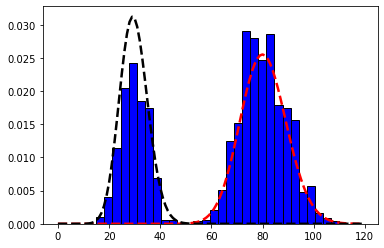

In [3]:
import matplotlib.pyplot as plt
import scipy.stats

plt.hist(data, bins = 30, color = 'blue', edgecolor = 'black', density = True)
plt.savefig("dist1.png")

pyro.param("lambdas_loc")
x = list(range(120))

y1 = scipy.stats.poisson.pmf(x, pyro.param("lambdas_loc")[0].item())
y2 = scipy.stats.poisson.pmf(x,pyro.param("lambdas_loc")[1].item())

plt.plot(x,y1 * pyro.param("weights_par")[0][0].item(), 'r--', linewidth=2.5)
plt.plot(x,y2 * pyro.param("weights_par")[0][1].item(), 'k--', linewidth=2.5)

In [15]:
from pyro.infer import SVI, TraceEnum_ELBO
import pyro
import pyro.distributions as dist
import torch
from torch.distributions import constraints

N1 = 500
N2 = 1000
lambda1 = dist.LogNormal(3.2,0.3).sample([N1])
lambda2 = dist.LogNormal(4.8,0.3).sample([N2])

# if parameters are passed through a Tensor, than the functions automatically samples N random variables with
# N the length of the input parameters Tensor, so we do not explicitly define the dimension in sample()
data_mix1 = dist.Poisson(lambda1).sample()
data_mix2 = dist.Poisson(lambda2).sample()

data = torch.cat((data_mix1, data_mix2),0)

def model(data, K = 2):
    # Global variable
    # Every distribution should be expressed as a pyro.sample statement
    weights = pyro.sample('weights', dist.Dirichlet(torch.ones(K) * 1/K))
    #This expression corresponds to the actual plate notation
    with pyro.plate('components', K):
        # Prior over the coefficients
        lambdas = pyro.sample('scale', dist.LogNormal(3.9, 0.9))
    with pyro.plate('data', len(data)):
        # Local variables
        
        # Automatically enumerates categorical variables
        assignment = pyro.sample('assignment', dist.Categorical(weights), infer={"enumerate": "parallel"})
        pyro.sample('obs', dist.Poisson(lambdas[assignment]), obs=data)



def guide(data, K = 2):
    lambdas_loc = pyro.param("lambdas_loc", lambda: dist.Uniform(2,4).sample([K]),constraint=constraints.positive)
    lambdas_scale = pyro.param("lambdas_scale", 
                               torch.ones([K]) * 0.1,constraint=constraints.positive)
    weights_par = pyro.param("weights_par", 
                             lambda: dist.Dirichlet(1/K*torch.ones(K))
                             .sample([1]),
                             constraint=constraints.simplex)
  
    pyro.sample('weights', dist.Dirichlet(weights_par))
    with pyro.plate('components', K):
        pyro.sample('scale', dist.LogNormal(lambdas_loc, lambdas_scale))

# At each run we clear the parameter store (so we reset the value of each parameter in the Pyro stack)
pyro.clear_param_store()
# We use the Adam optimizer, you can choose any of the PyTorch optimisers
optim = pyro.optim.Adam({'lr': 0.01})
# Here you can choose the loss function (other than the function you can also choose 
# the details of some computations)
elbo = TraceEnum_ELBO()
# Common interface class to perform inference
svi = SVI(model, guide, optim , loss=elbo)
losses = []
# Each cycle performs a step of optimization
for i in range(500):
    loss = svi.step(data)
    losses.append(loss)

print(pyro.param("lambdas_loc"))



tensor([4.8442, 3.2914], grad_fn=<AddBackward0>)


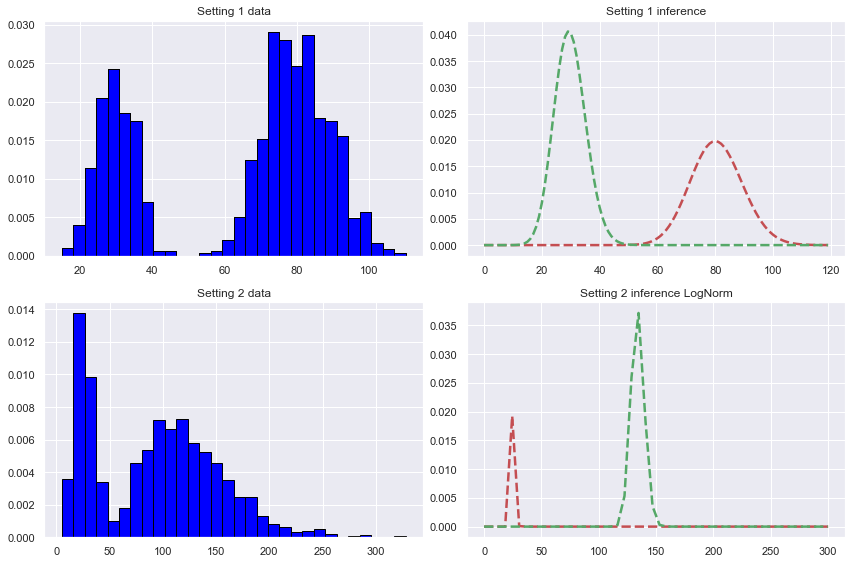

In [14]:
import numpy as np

fig, axes = plt.subplots(2,2, figsize = (12,8))
x = list(range(120))
x2 = np.linspace(0,300)
y3 = scipy.stats.lognorm.pdf(x2, scale = np.exp(pyro.param("lambdas_loc")[0].item()), s = pyro.param("lambdas_scale")[0].item())
y4 = scipy.stats.lognorm.pdf(x2, scale = np.exp(pyro.param("lambdas_loc")[1].item()),s = pyro.param("lambdas_scale")[1].item())


axes[0,0].hist(data2, bins = 30, color = 'blue', edgecolor = 'black', density = True)
axes[0,0].set_title('Setting 1 data')
axes[0,0].hist(data2, bins = 30, color = 'blue', edgecolor = 'black', density = True)
axes[0,1].plot(x,y1 * pyro.param("weights_par")[0][0].item(), 'r--', linewidth=2.5)
axes[0,1].plot(x,y2 * pyro.param("weights_par")[0][1].item(), 'g--', linewidth=2.5)
axes[0,1].set_title('Setting 1 inference')
axes[1,0].hist(data, bins = 30, color = 'blue', edgecolor = 'black', density = True)
axes[1,0].set_title('Setting 2 data')
axes[1,1].plot(x2,y3 * pyro.param("weights_par")[0][0].item(), 'r--', linewidth=2.5)
axes[1,1].plot(x2,y4 * pyro.param("weights_par")[0][1].item(), 'g--', linewidth=2.5)
axes[1,1].set_title('Setting 2 inference LogNorm')

fig.tight_layout()
#plt.show()
plt.savefig("pyroesempio1.png")


In [12]:
def full_guide(data, K = 2):
    with pyro.poutine.block(hide_types=["param"]):  # Keep our learned values of global parameters.
        guide(data)

    # Local variables.
    with pyro.plate('data', len(data)):
        assignment_probs = pyro.param('assignment_probs', torch.ones(len(data), K) / K,
                                      constraint=constraints.unit_interval)
        pyro.sample('assignment', dist.Categorical(assignment_probs))


svi = SVI(model, full_guide, optim, loss=elbo)
svi.loss(model, full_guide, data)

losses = []
for i in range(500):
    loss = svi.step(data)
    losses.append(loss)

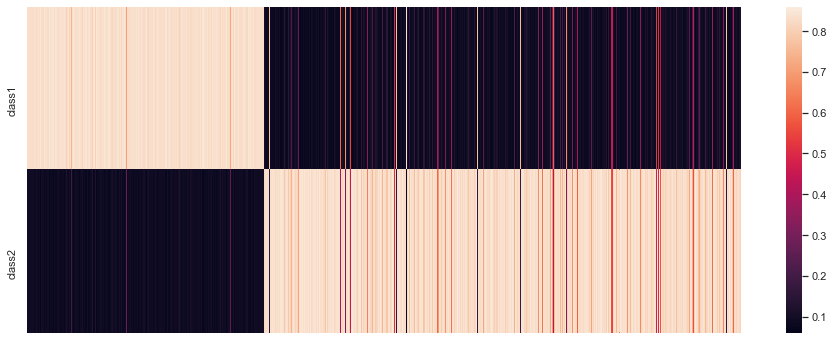

In [13]:
import seaborn as sns; sns.set()

heatmap = pyro.param('assignment_probs').detach().numpy().T
ax = sns.heatmap(heatmap)

ax.set_xticklabels("")
ax.set_yticklabels(["class1", "class2"])
ax.figure.set_size_inches(16, 6)

ax.figure.savefig("classes.png")
